In [1]:
import sys 
sys.path.append('../')

import torch
import matplotlib.pyplot as plt 
from einops import repeat

from src.toep_gmg import Toep_GMG1D
from src.green_net import GreenNet1D
from src.model import MLP
from src.utils import rl2_error

In [2]:
def Logarithm(pts):
    x = pts[...,0]
    y = pts[...,1]

    return torch.nan_to_num(torch.log((x-y).abs()), neginf=-8)

def ToepLogarithm(x):
    return torch.nan_to_num(torch.log((2*x).abs()), neginf=-8)

In [3]:
n = 7
device = torch.device('cpu')
model = GreenNet1D(n=n, kernel=Logarithm, device=device, sub_num=5)
F = torch.squeeze(1 - model.grid.x_h**2)
F = repeat(F, 'n -> n b', b=64)

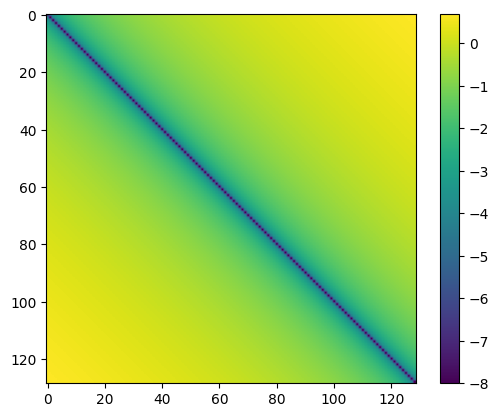

In [4]:
model.eval_K()
K_full = model.K_hh
plt.imshow(K_full.reshape(2**n+1, 2**n+1))
plt.gca().set_aspect('equal')
plt.colorbar()

torch.Size([129, 64])


Text(0.5, 1.0, 'output function U')

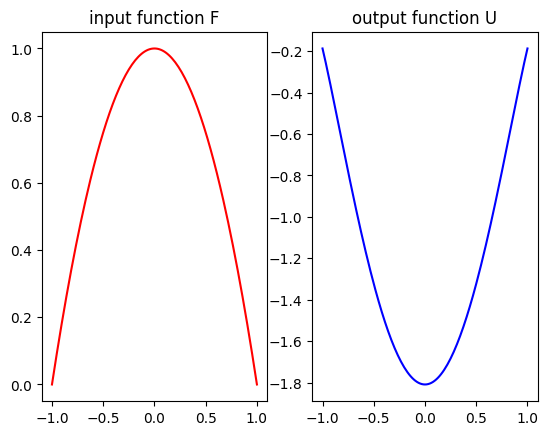

In [5]:
U_full = model.full_kint(F)
print(U_full.shape)

plt.subplot(121)
plt.plot(model.grid.x_h, F[:,0], '-r')
plt.title('input function F')
plt.subplot(122)
plt.plot(model.grid.x_h, U_full[:,0], '-b')
plt.title('output function U')

# Toep Green Net

In [6]:
# toep green net
m = 0
k = 0
toep_gmg = Toep_GMG1D(n, m, k, ToepLogarithm, device)

# coarest pts :  257
# correction :  0
ratio 257/257 = 100.00% 



In [7]:
toep_gmg.eval_ml_K()
toep_gmg.assemble_K()

In [8]:
K_toep_full = toep_gmg.K_h
K_full_ = torch.concatenate([K_full.reshape(2**n+1, 2**n+1)[:,0].flip(0), K_full.reshape(2**n+1,2**n+1)[0][1:]])

toeplitz kernel visualization

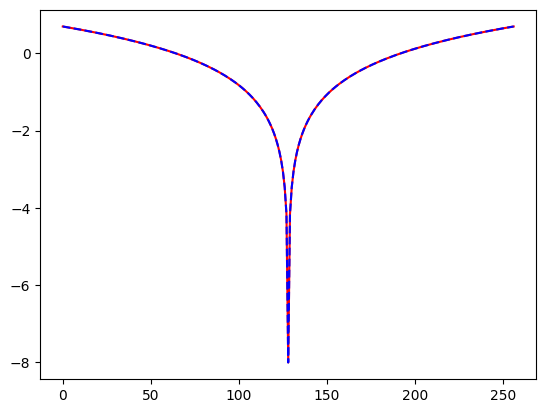

In [9]:
plt.plot(K_full_, '-r')
plt.plot(K_toep_full, '--b')

In [10]:
U_toep = toep_gmg.fft_kint(F)
rl2_error(U_toep, U_full)

tensor(1.8370e-07)

# Toep Green MG

influence of level of coarse : `k`

In [11]:
m = 0

for k in range(0, 4):
    toep_gmg = Toep_GMG1D(n, m, k, ToepLogarithm, device)
    toep_gmg.eval_ml_K()
    toep_gmg.assemble_K()
    U_toep = toep_gmg.fft_kint(F)
    print('k {:d} - {:.4f}'.format(k, rl2_error(U_toep, U_full)))

# coarest pts :  257
# correction :  0
ratio 257/257 = 100.00% 

k 0 - 0.0000
# coarest pts :  129
# correction :  0
ratio 129/257 = 50.19% 

k 1 - 0.0279
# coarest pts :  65
# correction :  0
ratio 65/257 = 25.29% 

k 2 - 0.0951
# coarest pts :  33
# correction :  0
ratio 33/257 = 12.84% 

k 3 - 0.2536


influence of correction range : `c`

In [13]:
k = 2

for m in [0, 1, 3, 5, 7, 15, 31]:
    toep_gmg = Toep_GMG1D(n, m, k, ToepLogarithm, device)
    toep_gmg.eval_ml_K()
    toep_gmg.assemble_K()
    U_toep = toep_gmg.fft_kint(F)
    print('k {:d} m {:d} - {:.4f}'.format(k, m, rl2_error(U_toep, U_full)))

# coarest pts :  65
# correction :  0
ratio 65/257 = 25.29% 

k 2 m 0 - 0.0951
# coarest pts :  65
# correction :  0
ratio 65/257 = 25.29% 

k 2 m 1 - 0.0951
# coarest pts :  65
# correction :  4
ratio 69/257 = 26.85% 

k 2 m 3 - 0.0059
# coarest pts :  65
# correction :  8
ratio 73/257 = 28.40% 

k 2 m 5 - 0.0030
# coarest pts :  65
# correction :  12
ratio 77/257 = 29.96% 

k 2 m 7 - 0.0019
# coarest pts :  65
# correction :  28
ratio 93/257 = 36.19% 

k 2 m 15 - 0.0007
# coarest pts :  65
# correction :  60
ratio 125/257 = 48.64% 

k 2 m 31 - 0.0002


In [ ]:
2 + 4 + 6 + 14 + 30

56